## Writeup Template

### You can use this file as a template for your writeup if you want to submit it as a markdown file, but feel free to use some other method and submit a pdf if you prefer.

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* 1-Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* 2-Apply a distortion correction to raw images.
* 3-Use color transforms, gradients, etc., to create a thresholded binary image.
* 4-Apply a perspective transform to rectify binary image ("birds-eye view").
* 5-Detect lane pixels and fit to find the lane boundary.
* 6-Determine the curvature of the lane and vehicle position with respect to center.
* 7-Warp the detected lane boundaries back onto the original image.
* 8-Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [8]:
# Importing required packages

import numpy as np
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from IPython.display import HTML
!pip install imageio_ffmpeg
from moviepy.editor import VideoFileClip

%matplotlib inline


You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [28]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline




class Line:
    def __init__(self):
        print('-----  Line Class initiated  -----')
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
    def CalibratingCamera(self,FilesDirectory, X_cells=9 ,Y_cells=6):
        '''
        Function to Calibrate Distortion of Camera images caused by the bending light rays with the lens associated with the camera.
        Here some random camera photos of Chessboard have taken in understanding the light rays bending positions in Image and Calibration
        has done with the use of OpenCV findChessboardCorners and CalibrateCamera functions.

        Parameters
        ----------
        FilesDirectory     -  Folder address of random Chessboard images taken by the Camera
        X_cells            -  Number of cells in horizontal Direction of Chess board image taken by Camera
        Y_cells            -  Number of cells in Vertical Direction of Chess board image taken by Camera

        Returns
        -------
        dst                -  Destination Coefficients to undistort the Image retrieved from CalibrateCamera
        mtx                -  calculated values for the camera matrix
        '''
        # Defining a lists to store Image points and image associated object points
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Defining the object points and associated matrix points to calibrate
        objp = np.zeros((X_cells*Y_cells,3), np.float32)
        objp[:,:2] = np.mgrid[0:X_cells,0:Y_cells].T.reshape(-1,2)


        # Opening Calibration associated Images one by one
        for i,file in enumerate(os.listdir(FilesDirectory)):
            Image = cv2.imread(os.path.join(FilesDirectory,file))
            GrayImage = cv2.cvtColor(Image,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(GrayImage, (X_cells,Y_cells),None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)



        # Testing the sample image for calibration
        Image = cv2.imread('./camera_cal/calibration1.jpg')

        # Calibrating the Camera based on the Retrieved Image points and Object points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, Image.shape[:-1][::-1],None,None)
        dst = cv2.undistort(Image, mtx, dist, None, mtx)

        # Saving the Calibrated results information for further use
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open( "CameraCalibration.data", "wb" ) )

        # Visualize undistortion
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        f.subplots_adjust(hspace = .2, wspace=.05)
        ax1.imshow(Image)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=30)
        return mtx, dist

    def PerspectiveTransform(self, img, SourcePoints, DestinationPoints):
        '''
        Transforming the concentrated Source points image to Destination points Image. Depends on the Source points
        Coordinates given, Perspective transformation image can be genrated with the use of OpenCV.getPerspectiveTransform
        Function.

        Parameters
        ----------
        img            -  calculated values for the camera matrix
        SourcePoints   -  Coordinate 4 points selected in the given image
        DestinationPoints - Shape of required transformation output 

        Returns
        -------
        warped         -  Transformed Source points image
        Minv           -  Inverse perspective transformation matrix
        M              -  Perspective transforamtion matrix

        '''

        h,w = img.shape[:2]

        M = cv2.getPerspectiveTransform(SourcePoints, DestinationPoints)
        Minv = cv2.getPerspectiveTransform(DestinationPoints, SourcePoints)
        # use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
        return warped, M, Minv

    # undistort image using camera calibration matrix from above
    def undistort(self, img):
        '''
        Function to undistorting the image caused by the bending of light rays with the lens associated with the camera

        Parameters
        ----------
        img                -  calculated values for the camera matrix
        dst                -  Destination Coefficients to undistort the Image retrieved from CalibrateCamera
        mtx                -  calculated values for the camera matrix

        Results
        -------
        undist             -  Undistorted image 

        '''
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        return undist


    def Plot_Images(self, images,labels):
        # Visualize sobel absolute threshold
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        f.subplots_adjust(hspace = .2, wspace=.05)
        ax1.imshow(images[0])
        ax1.set_title(labels[0], fontsize=30)
        ax2.imshow(images[1], cmap='gray')
        ax2.set_title(labels[1], fontsize=30)


    def abs_sobel_thresh(self, img, orient='x', thresh_min=0, thresh_max=255):
        '''
        Function that applies Sobel x and y, then computes the Absolute values of Soble x direction of the gradient
        and applies a threshold values to filter the pixels from image.

        Parameters
        ----------
        img            -   Image to apply the Operation
        orient         -   Axis associated with the image in applying Operation( X or Y)
        thresh_min     -   Minimum Threshold values to filter the pixels from image 
        thresh_max     -   Maximum Threshold values to filter the pixels from image 

        Returns
        -------
        sxbinary       -   Output Image after applying Sobel filter operation

        '''
        # Apply the following steps to img
        # 1) Convert to grayscale
        binary_output = np.copy(img) # Remove this line
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        # 3) Take the absolute value of the derivative or gradient
        abs_sobelx = np.absolute(sobelx)
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        sxbinary = np.zeros_like(scaled_sobel)
        # 5) Create a mask of 1's where the scaled gradient magnitude 
                # is > thresh_min and < thresh_max
        # 6) Return this mask as your binary_output image
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        return sxbinary

    def mag_thresh(self, img, sobel_kernel=3, mag_thresh=(0, 255)):
        '''
        Function that applies Sobel x and y, then computes the magnitude of the gradient
        and applies a threshold values to filter the pixels from image.

        Parameters
        ----------
        img            -   Image to apply the Operation
        sobel_kernel   -   Kernel size of matrix chosen in additive, multiplive operation of Sobel filter
        mag_thresh     -   maximum and minimum Threshold values to filter the pixels from image 

        Returns
        -------
        binary_output  -   Output Image after applying Sobel filter operation

        '''
        # Apply the following steps to img
        # 1) Convert to grayscale
        binary_output = np.copy(img) # Remove this line
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        # 3) Calculate the magnitude 
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        scale_factor = np.max(gradmag)/255 
        # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        # 5) Create a binary mask where mag thresholds are met
        # 6) Return this mask as your binary_output image
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        return binary_output


    def dir_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):

        '''
        Function that applies Sobel x and y, then computes the direction of the gradient
        and applies a threshold values to filter the pixels from image.

        Parameters
        ----------
        img            -   Image to apply the Operation
        sobel_kernel   -   Kernel size of matrix chosen in additive, multiplive operation of Sobel filter
        thresh         -   maximum and minimum Threshold values to filter the pixels from image 

        Returns
        -------
        binary_output  -   Output Image after applying Sobel filter operation

        '''

        # Apply the following steps to img
        # 1) Convert to grayscale
        binary_output = np.copy(img) # Remove this line
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        # 3) Take the absolute value of the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        # 5) Create a binary mask where direction thresholds are met
        binary_output =  np.zeros_like(absgraddir)
        # 6) Return this mask as your binary_output image
        # Calculate the x and y gradients
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        return binary_output


    # Define a function that thresholds the S-channel of HLS
    # Use exclusive lower bound (>) and inclusive upper (<=)
    def hls_select(self, img, thresh=(0, 255),channel=2):

        '''
        Function to convert and Extracting the HLS( Hue, Lightness , Saturation ) color space from RGB Image and allows
        to select the individual color spaces of H, L and S. Function also allows to apply maximum and minimum threshold 
        values on pixels of image in extracting infomration.

        Parameters
        ----------
        img            -   Image to apply the Operation
        thresh         -   maximum and minimum Threshold values to filter the pixels from image 
        channel        -   Variable allows to select individual color channel (H,L,S) of an Image

        Returns
        -------
        binary_output  -   Output Image after applying Channel selection and filter in refining the image

        '''
        # 1) Convert to HLS color space
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        # 2) Apply a threshold to the S channel
        s_channel = hls[:,:,channel]
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
        # 3) Return a binary image of threshold result
        return binary_output
    
    
    def Lab_select(self, img, thresh=(0, 255),channel=2):

        '''
        Function to convert and Extracting the Lab color space from RGB Image and allows
        to select the individual color spaces of L, a and b. Function also allows to apply maximum and minimum threshold 
        values on pixels of image in extracting infomration.

        Parameters
        ----------
        img            -   Image to apply the Operation
        thresh         -   maximum and minimum Threshold values to filter the pixels from image 
        channel        -   Variable allows to select individual color channel (L,a,b) of an Image

        Returns
        -------
        binary_output  -   Output Image after applying Channel selection and filter in refining the image

        '''
        # 1) Convert to HLS color space
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        # 2) Apply a threshold to the S channel
        s_channel = lab[:,:,channel]
        # 3) Return a binary image of threshold result
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
        return binary_output


    # Image processing pipeline, reads raw image and returns binary image with lane lines identified
    def ImageProcessingPipeline(self, img):
        '''
        Function to apply step by step Operations of Image processing in extracting the Required cotent of Image
        Operations to be applied on Image
            - Undistorting Image
            - Perspective Transformation of Image
            - Sobel Operation with absolute value of kernel
            - Sobel Operation with Magnitude Gradient threshold
            - Sobel Operation with direction Threshold 
            - Converting RGB image to  HLS( Hue, Lightness , Saturation )

        Parameters
        ----------
        img            -   Image to apply the Operation

        Returns
        -------
        combined       -   Output Image once after applying required image processing Functions


        '''

        # Undistort
        img_undistort = self.undistort(img)

        # Perspective Transform
        TransformedImage, M, Minv = self.PerspectiveTransform(img_undistort, SourcePoints, DestinationPoints)
        # Sobel with Absolute Sobel X and y channel thresholds
        SobelThresholdImage = self.abs_sobel_thresh(TransformedImage, thresh_min=20,thresh_max=80)
        # Sobel with Magnitude soble x and y channel thresholds
        SobelMagThresholdImage = self.mag_thresh(TransformedImage, sobel_kernel=3, mag_thresh=(20,111))
        # Sobel with Direction Treshold on Sobel x and y channel thresholds
        DirectionThresholdedImage = self.dir_threshold(TransformedImage, sobel_kernel=15, thresh=(0.7, 1.3))
        # HLS S-channel Threshold 
        hls_binary_s = self.hls_select(TransformedImage, thresh=(140, 250),channel=2)
        # HLS L-channel Threshold 
        hls_binary_l = self.hls_select(TransformedImage, thresh=(150, 250),channel=1)


        # Combine HLS and Lab B channel thresholds
        combined = np.zeros_like(hls_binary_s)
        combined[(hls_binary_s == 1) | (hls_binary_s == 1)] = 1
        return combined, Minv


    def find_lane_pixels(self, binary_warped):
        '''
        Function to apply sliding window of Operation in selecting the image window by window from bottom to top 
        in recognizing the line pixels concentration from bottom to top based on the selected number of Window size.
        The selection of pixels is also depends on the threshold considered.

        Parameters
        ----------
        bineary_warped   -  Output of Perspective Transform which is showcasing the lane lines.

        Returns
        -------
        leftx, lefty, rightx, righty  -  left and right line pixel positions respresenting the line line concentrated pixels.
         left_fit, right_fit          -  Second Order polynomial Equation coeffiecients of left and right line polynomial Equations
        left_lane_inds, right_lane_inds  - Indexes associated with the left and right window inside pixels,pixel values contained
                                            within the boundaries of a given sliding window


        '''
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 8
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        rectangle_data = []
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]


            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            ### TO-DO: If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]


        left_fit, right_fit = (None, None)
        # Fit a second order polynomial to each\
        if len(leftx) != 0:
            left_fit = np.polyfit(lefty, leftx, 2)
        if len(rightx) != 0:
            right_fit = np.polyfit(righty, rightx, 2)

#         visualization_data = (rectangle_data, histogram)

        return leftx, lefty, rightx, righty, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds


    def fit_polynomial(self, binary_warped):
        '''
        Function to apply second order polynomials to the lane line pixels in extracting connected lines of pixels.

        Parameters
        ----------
        binary_warped   -  Output of Perspective Transform which is showcasing the lane lines.

        Returns
        -------
        out_img          -  Polynomial Line imposed lane lines image 


        '''
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img, _, _, _, _ = self.find_lane_pixels(binary_warped)

        ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

        return out_img




    def polyfit_using_prev_fit(self, binary_warped, left_fit_prev, right_fit_prev):
        '''
        Method to fit polynomial to binary image based upon a assumption that the fit will not change significantly 
        from one video frame to the next

        Parameters
        ----------
        binary_warped   -  Output of Perspective Transform which is showcasing the lane lines.
        left_fit, right_fit          -  Second Order polynomial Equation coeffiecients of left and right line polynomial Equations

        '''
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 80
        left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                          (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                           (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        left_fit_new, right_fit_new = (None, None)
        if len(leftx) != 0:
            # Fit a second order polynomial to each
            left_fit_new = np.polyfit(lefty, leftx, 2)
        if len(rightx) != 0:
            right_fit_new = np.polyfit(righty, rightx, 2)
        return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


    def search_around_poly(self, hls_binary):
        '''
        Function in sliding window template across the image from left to right and any overlapping values are summed together,
        creating the convolved signal.

        Parameters
        ----------
        hls_binary     -  Perspective transformed image after converting to gray scale as input

        Returns
        -------
        left_lane_inds, right_lane_inds  -  Indexes associated with the left and right window inside pixels,pixel values contained
                                            within the boundaries of a given sliding window

        '''
        margin = 80
        _, _, _, _, _, left_fit, right_fit, left_lane_inds, right_lane_inds = self.find_lane_pixels(hls_binary)

        left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = self.polyfit_using_prev_fit(hls_binary, left_fit, right_fit)

        # Generate x and y values for plotting
        ploty = np.linspace(0, hls_binary.shape[0]-1, hls_binary.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
        right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.uint8(np.dstack((hls_binary, hls_binary, hls_binary))*255)
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        nonzero = hls_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area (OLD FIT)
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx2, ploty, color='yellow')
        plt.plot(right_fitx2, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        return left_lane_inds, right_lane_inds


    # Method to determine radius of curvature and distance from lane center 
    # based on binary image, polynomial fit, and L and R lane pixel indices
    def CurvatureCalculationDistancefromLane(self, hls_binary, left_fit, right_fit, l_lane_inds, r_lane_inds):
        '''
        Function in Calculating the Curvature of lane lines with the use of Second order polynomial Equations coeffiecients.
        For converting the pixel space to Meters, assumptions have made in calculating the properional pixel to meter space.
        Once after the pixel space covertion with the use of second order polynomial coeffiecients distance and radius infomration updated

        Parameters
        ----------
        hls_binary      -   Perspective transformed image after converting to gray scale as input
        left_fit, right_fit          -  Second Order polynomial Equation coeffiecients of left and right line polynomial Equations
        l_lane_inds, r_lane_inds     -  Indexes associated with the left and right window inside pixels,pixel values contained
                                            within the boundaries of a given sliding window


        '''
        # Assumptions in converting in x and y from pixels space to meters
        ym_per_pix = 2.80/100 
        xm_per_pix = 2.96/300 
        left_curverad, right_curverad, center_dist = (0, 0, 0)
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        h = hls_binary.shape[0]
        ploty = np.linspace(0, h-1, h)
        y_eval = np.max(ploty)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = hls_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Again, extract left and right line pixel positions
        leftx = nonzerox[l_lane_inds]
        lefty = nonzeroy[l_lane_inds] 
        rightx = nonzerox[r_lane_inds]
        righty = nonzeroy[r_lane_inds]

        if len(leftx) != 0 and len(rightx) != 0:
            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
            # Calculate the new radii of curvature
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
            # Now our radius of curvature is in meters

        # Distance from center is image x midpoint - mean of left_fit and right_fit intercepts 
        if right_fit is not None and left_fit is not None:
            car_position = hls_binary.shape[1]/2
            left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
            right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
            lane_center_position = (right_fit_x_int + left_fit_x_int) /2
            center_dist = (car_position - lane_center_position) * xm_per_pix
        return left_curverad, right_curverad, center_dist

    def LaneImpositionOnImage(self, original_img, binary_img, left_fit, right_fit, Minv):
        '''
        Function to Impose a detected lane line on an image

        Parameters
        ----------
        Original_img     -  Original RGB Image used in extracting the lanes infomration
        binary_img       -  Perspective transformed image after converting to gray scale as input
        left_fit, right_fit   -  Second Order polynomial Equation coeffiecients of left and right line polynomial Equations

        Returns
        -------
        result           -  The output lane imposed image


        '''

        new_img = np.copy(original_img)
        if left_fit is None or right_fit is None:
            return original_img
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        h,w = binary_img.shape
        ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
        # Combine the result with the original image
        result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
        return result

    def LaneCurvatureImpositionImage(self, original_img, curv_rad, center_dist):
        '''
        Function to draw the detected lane and Curvature associated with the lane on an image.

        Parameters
        ----------
        original_img    -  Original RGB Image used in extracting the lanes infomration
        curv_rad        -  Radius detected associated with the Curvature in image
        center_dist     -  Distance from the center for the curvature

        Results
        -------
        new_img         -  Output image imposed with the Curvature and radius information
        '''

        new_img = np.copy(original_img)
        h = new_img.shape[0]
        font = cv2.FONT_HERSHEY_DUPLEX
        text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
        cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
        direction = ''
        if center_dist > 0:
            direction = 'right'
        elif center_dist < 0:
            direction = 'left'
        abs_center_dist = abs(center_dist)
        text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
        cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
        return new_img

    def VidoePipeline(self, Image):
        '''
        Function to apply individual preprocessing operations on Image one by one with variable selection of parameters 
        required for the Preprocessig Operations.


        '''
        mtx, dst = self.CalibratingCamera('./camera_cal')
        
        GrayImage = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)

        UndistrtedImage = self.undistort(Image)

        h, w = Image.shape[:2]

        # define source points 
        SourcePoints = np.float32([(575,464), (700,464), (258,682), (900,682)])
        # define Destination points
        DestinationPoints = np.float32([(450,0), (w-450,0), (450,h), (w-450,h)])

        TransformedImage, M, Minv = self.PerspectiveTransform(Image, SourcePoints, DestinationPoints)


        hls_binary = self.hls_select(TransformedImage, thresh=(150, 250),channel=1)
        Lab_l_binary = LineObject.Lab_select(TransformedImage, thresh=(140, 250),channel=0)

        _, _, _, _, _, left_fit, right_fit, left_lane_inds, right_lane_inds = self.find_lane_pixels(Lab_l_binary)
        rad_l, rad_r, d_center =self.CurvatureCalculationDistancefromLane(Lab_l_binary, left_fit, right_fit, left_lane_inds, right_lane_inds)


        LaneImposedImage = self.LaneImpositionOnImage(Image, Lab_l_binary, left_fit, right_fit, Minv)
        plt.imshow(LaneImposedImage)


        LaneCurvatureImposedImage = self.LaneCurvatureImpositionImage(LaneImposedImage, (rad_l+rad_r)/2, d_center)
        #plt.imshow(LaneCurvatureImposedImage)
        return LaneCurvatureImposedImage


In [10]:
LineObject = Line()

-----  Line Class initiated  -----


###  1 ) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
### Calibrating Camera using Chess board corners

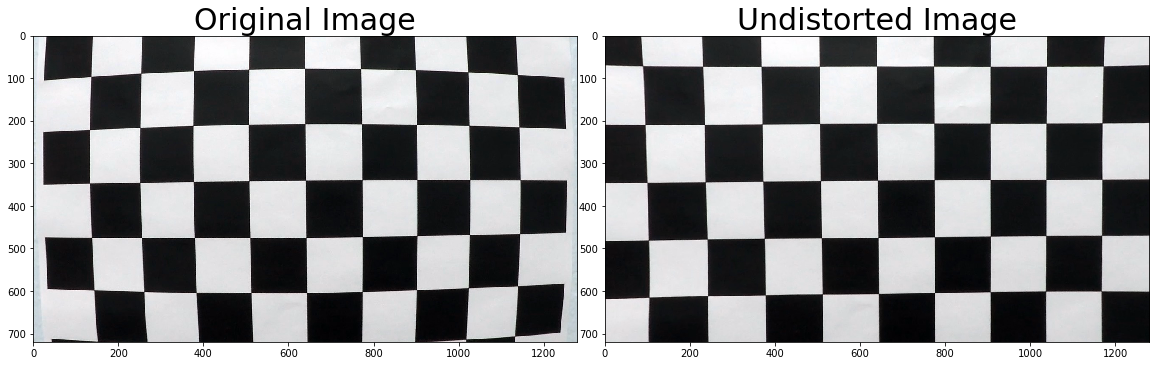

In [11]:
mtx, dist = LineObject.CalibratingCamera('./camera_cal')

### 2) Apply a distortion correction to raw images.

### 4)  Apply a perspective transform to rectify binary image ("birds-eye view").
### Perspective Transform

Text(0.5,1,'Perspective transformed Image')

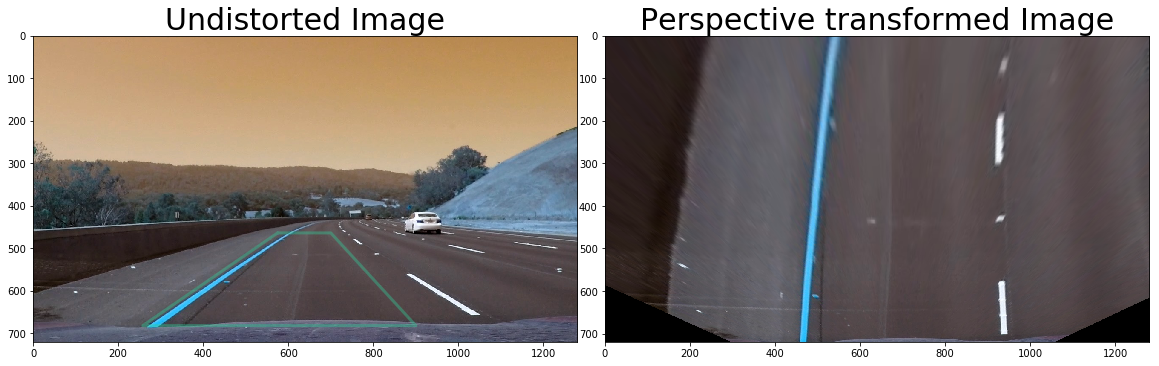

In [12]:

Image = cv2.imread('./test_images/test3.jpg')
GrayImage = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)

UndistrtedImage = LineObject.undistort(Image)

h, w = Image.shape[:2]

# define source and destination points 
SourcePoints = np.float32([(575,464), (700,464), (258,682), (900,682)])
DestinationPoints = np.float32([(450,0), (w-450,0), (450,h), (w-450,h)])

TransformedImage, M, Minv = LineObject.PerspectiveTransform(Image, SourcePoints, DestinationPoints)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(Image)
x = [SourcePoints[0][0],SourcePoints[2][0],SourcePoints[3][0],SourcePoints[1][0],SourcePoints[0][0]]
y = [SourcePoints[0][1],SourcePoints[2][1],SourcePoints[3][1],SourcePoints[1][1],SourcePoints[0][1]]

ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(TransformedImage)
ax2.set_title('Perspective transformed Image', fontsize=30)



### 3) Use color transforms, gradients, etc., to create a thresholded binary image.


### Sobel Filter in Derivative Operation to  an Image

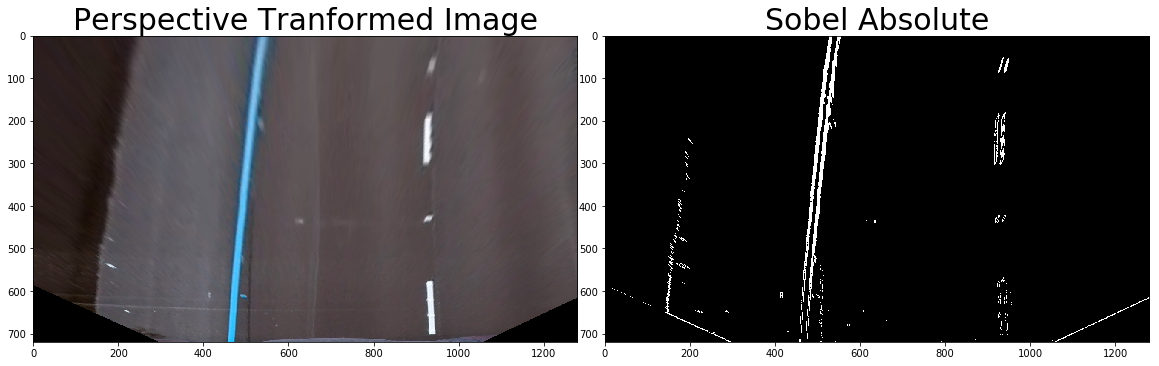

In [13]:
SobelThresholdImage = LineObject.abs_sobel_thresh(TransformedImage, thresh_min=20,thresh_max=80)
LineObject.Plot_Images([TransformedImage,SobelThresholdImage],['Perspective Tranformed Image','Sobel Absolute'])

### Sobel Filter with the use Gradient Magnitude threshold 

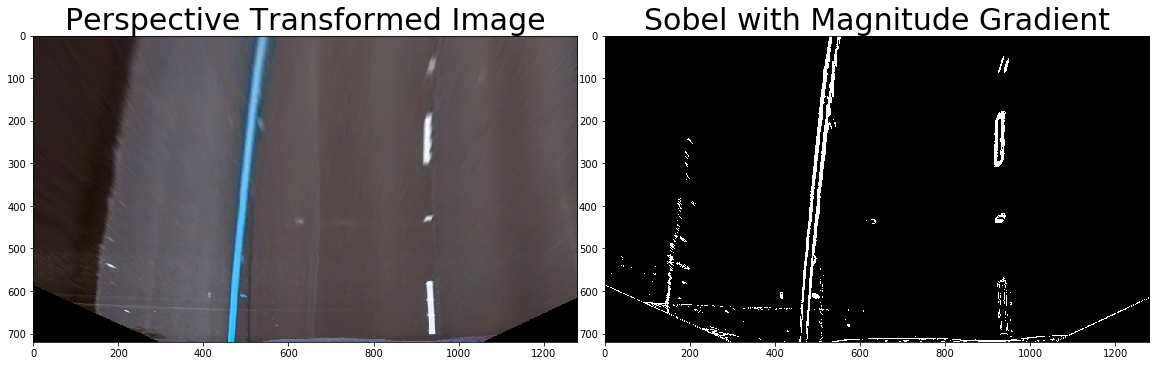

In [14]:
SobelMagThresholdImage = LineObject.mag_thresh(TransformedImage, sobel_kernel=3, mag_thresh=(20,111))
LineObject.Plot_Images([TransformedImage,SobelMagThresholdImage],['Perspective Transformed Image','Sobel with Magnitude Gradient'])

### Sobel function with the use of Direction Gradient Funtion

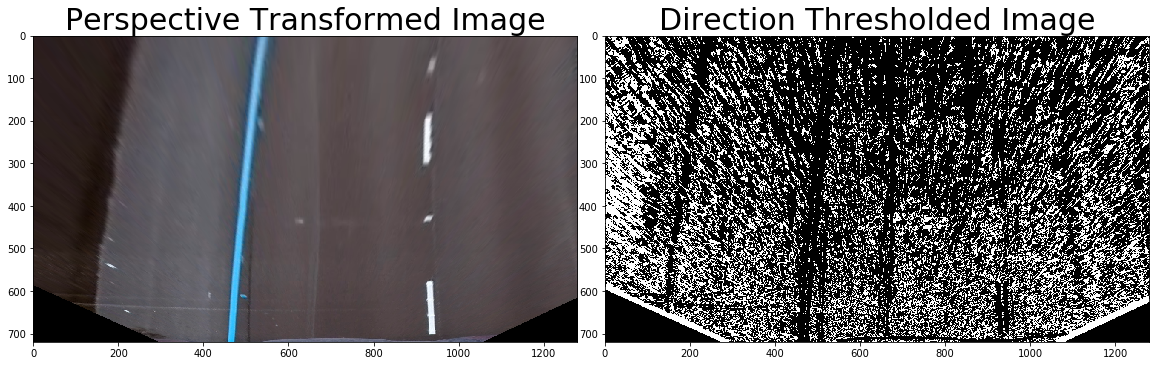

In [15]:
DirectionThresholdedImage = LineObject.dir_threshold(TransformedImage, sobel_kernel=15, thresh=(0.7, 1.3))
LineObject.Plot_Images([TransformedImage,DirectionThresholdedImage],['Perspective Transformed Image','Direction Thresholded Image'])

### 3) Use color transforms 
### HLS Transform
### HLS Transform to an Image and applying threshold to S channel

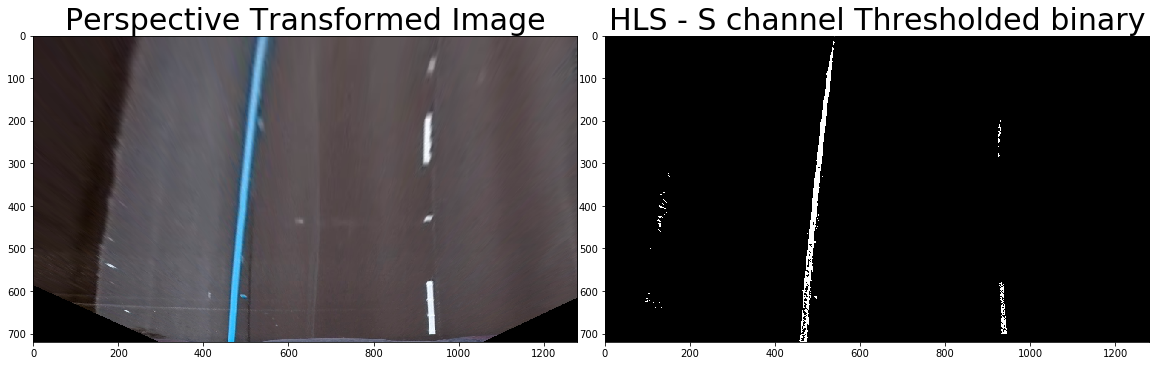

In [16]:
hls_s_binary = LineObject.hls_select(TransformedImage, thresh=(140, 250),channel=2)
LineObject.Plot_Images([TransformedImage,hls_s_binary],['Perspective Transformed Image','HLS - S channel Thresholded binary'])

### HLS Transform to an Image and applying threshold to L channel

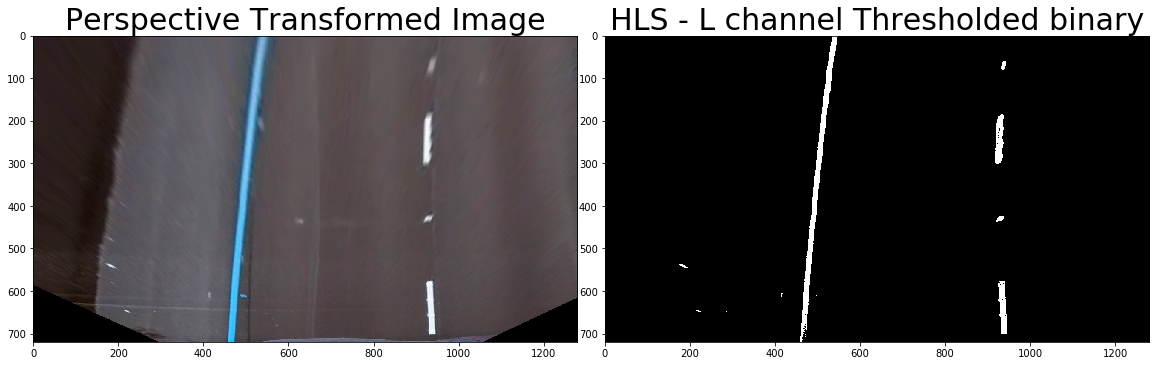

In [17]:
hls_l_binary = LineObject.hls_select(TransformedImage, thresh=(150, 250),channel=1)
LineObject.Plot_Images([TransformedImage,hls_l_binary],['Perspective Transformed Image','HLS - L channel Thresholded binary'])

### HLS Transform to an Image and applying threshold to H channel

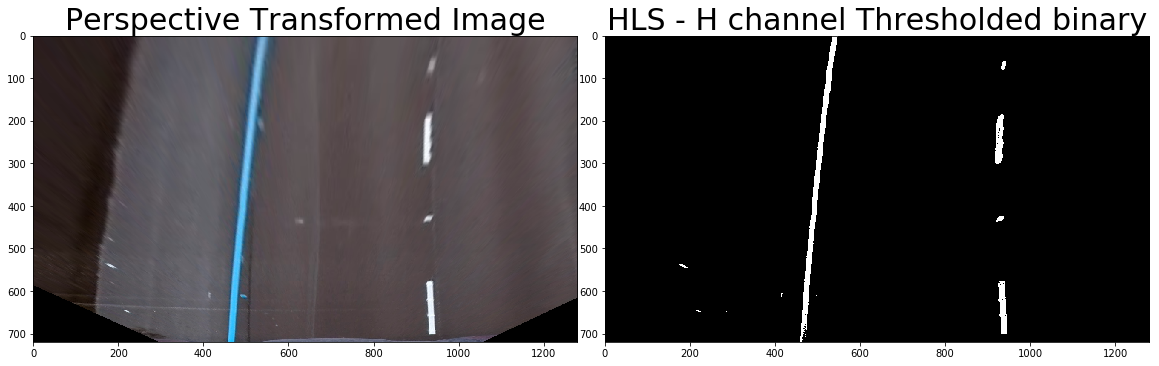

In [18]:
hls_h_binary = LineObject.hls_select(TransformedImage, thresh=(150, 250),channel=1)
LineObject.Plot_Images([TransformedImage,hls_h_binary],['Perspective Transformed Image','HLS - H channel Thresholded binary'])

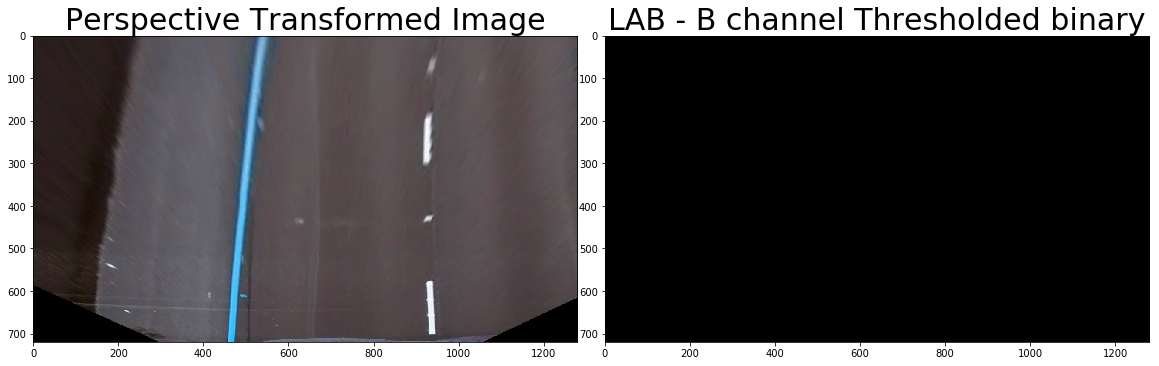

In [19]:
Lab_b_binary = LineObject.Lab_select(TransformedImage, thresh=(0, 250),channel=2)
LineObject.Plot_Images([TransformedImage,Lab_b_binary],['Perspective Transformed Image','LAB - B channel Thresholded binary'])

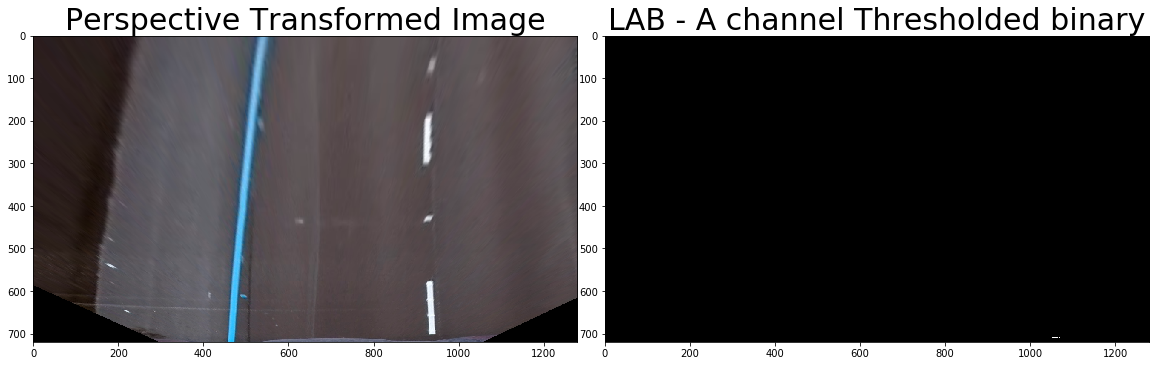

In [20]:
Lab_a_binary = LineObject.Lab_select(TransformedImage, thresh=(140, 250),channel=1)
LineObject.Plot_Images([TransformedImage,Lab_a_binary],['Perspective Transformed Image','LAB - A channel Thresholded binary'])

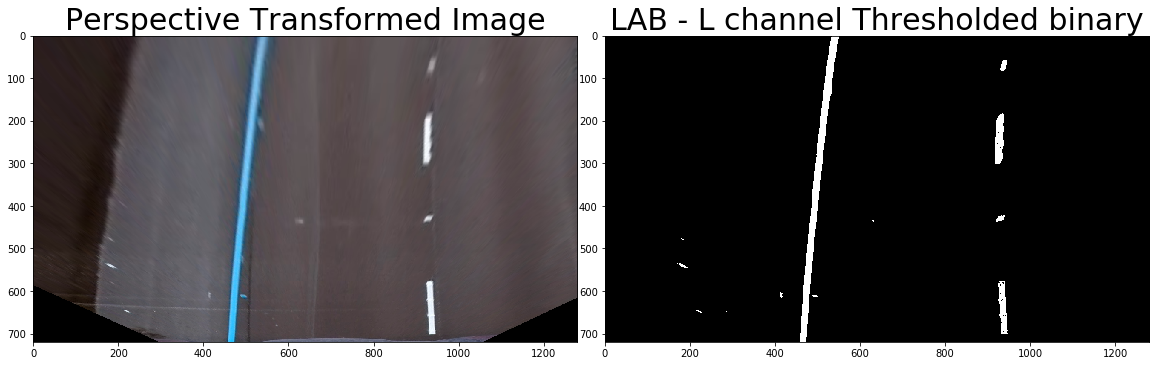

In [21]:
Lab_l_binary = LineObject.Lab_select(TransformedImage, thresh=(140, 250),channel=0)
LineObject.Plot_Images([TransformedImage,Lab_l_binary],['Perspective Transformed Image','LAB - L channel Thresholded binary'])

### Applying Image Processing Pipeline on given set of Images

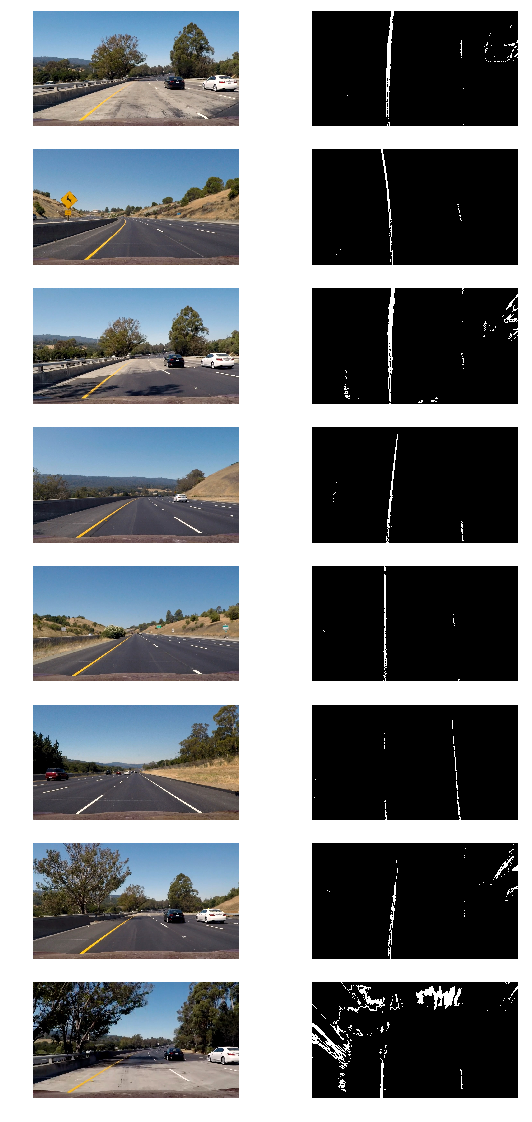

In [22]:
fig, axs = plt.subplots(len(os.listdir('./test_images')),2,figsize=(10,20))
fig.subplots_adjust(hspace=0.2, wspace=0.001)
axs = axs.ravel()

i = 0
for file in os.listdir('./test_images')[::-1]:
    Image = cv2.imread(os.path.join('./test_images',file))
    GrayImage = cv2.cvtColor(Image,cv2.COLOR_BGR2RGB)
    FilteredImage, Minv = LineObject.ImageProcessingPipeline(GrayImage)
    axs[i].imshow(GrayImage)
    axs[i].axis('off')
    i = i+1
    axs[i].imshow(FilteredImage,cmap='gray')
    axs[i].axis('off')
    i = i+1

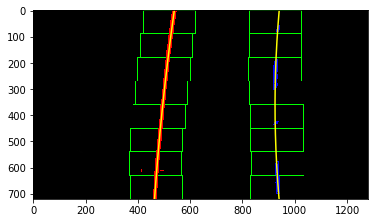

In [29]:

# Load our image
out_img = LineObject.fit_polynomial(Lab_l_binary)

plt.imshow(out_img)

##  6)    Determine the curvature of the lane and vehicle position with respect to center.

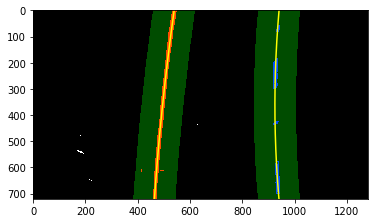

In [31]:
left_lane_inds, right_lane_inds =  LineObject.search_around_poly(Lab_l_binary)

### 7) Radius of Curvature and Distance from Lane Center Calculation

In [32]:
_, _, _, _, _, left_fit, right_fit, left_lane_inds, right_lane_inds = LineObject.find_lane_pixels(Lab_l_binary)
rad_l, rad_r, d_center = LineObject.CurvatureCalculationDistancefromLane(Lab_l_binary, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 814.8879924034446 m, 329.45808131006623 m
Distance from lane center for example: -0.6115648273468354 m


## 8) -Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

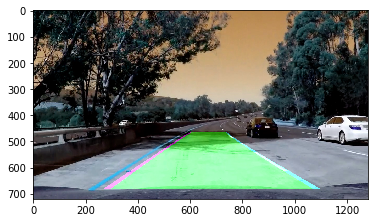

In [33]:
LaneImposedImage = LineObject.LaneImpositionOnImage(Image, Lab_l_binary, left_fit, right_fit, Minv)
plt.imshow(LaneImposedImage)


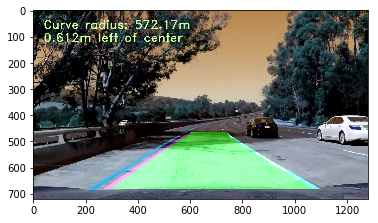

In [34]:
LaneCurvatureImposedImage = LineObject.LaneCurvatureImpositionImage(LaneImposedImage, (rad_l+rad_r)/2, d_center)
plt.imshow(LaneCurvatureImposedImage)


-----  Line Class initiated  -----
-----  Line Class initiated  -----
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:04<00:00,  3.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 42s, sys: 7.67 s, total: 3min 50s
Wall time: 6min 7s


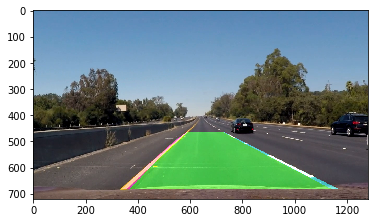

In [35]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(LineObject.VidoePipeline)
%time processed_video.write_videofile(video_output1, audio=False)

In [36]:
from IPython.display import Video
Video("project_video_output.mp4")